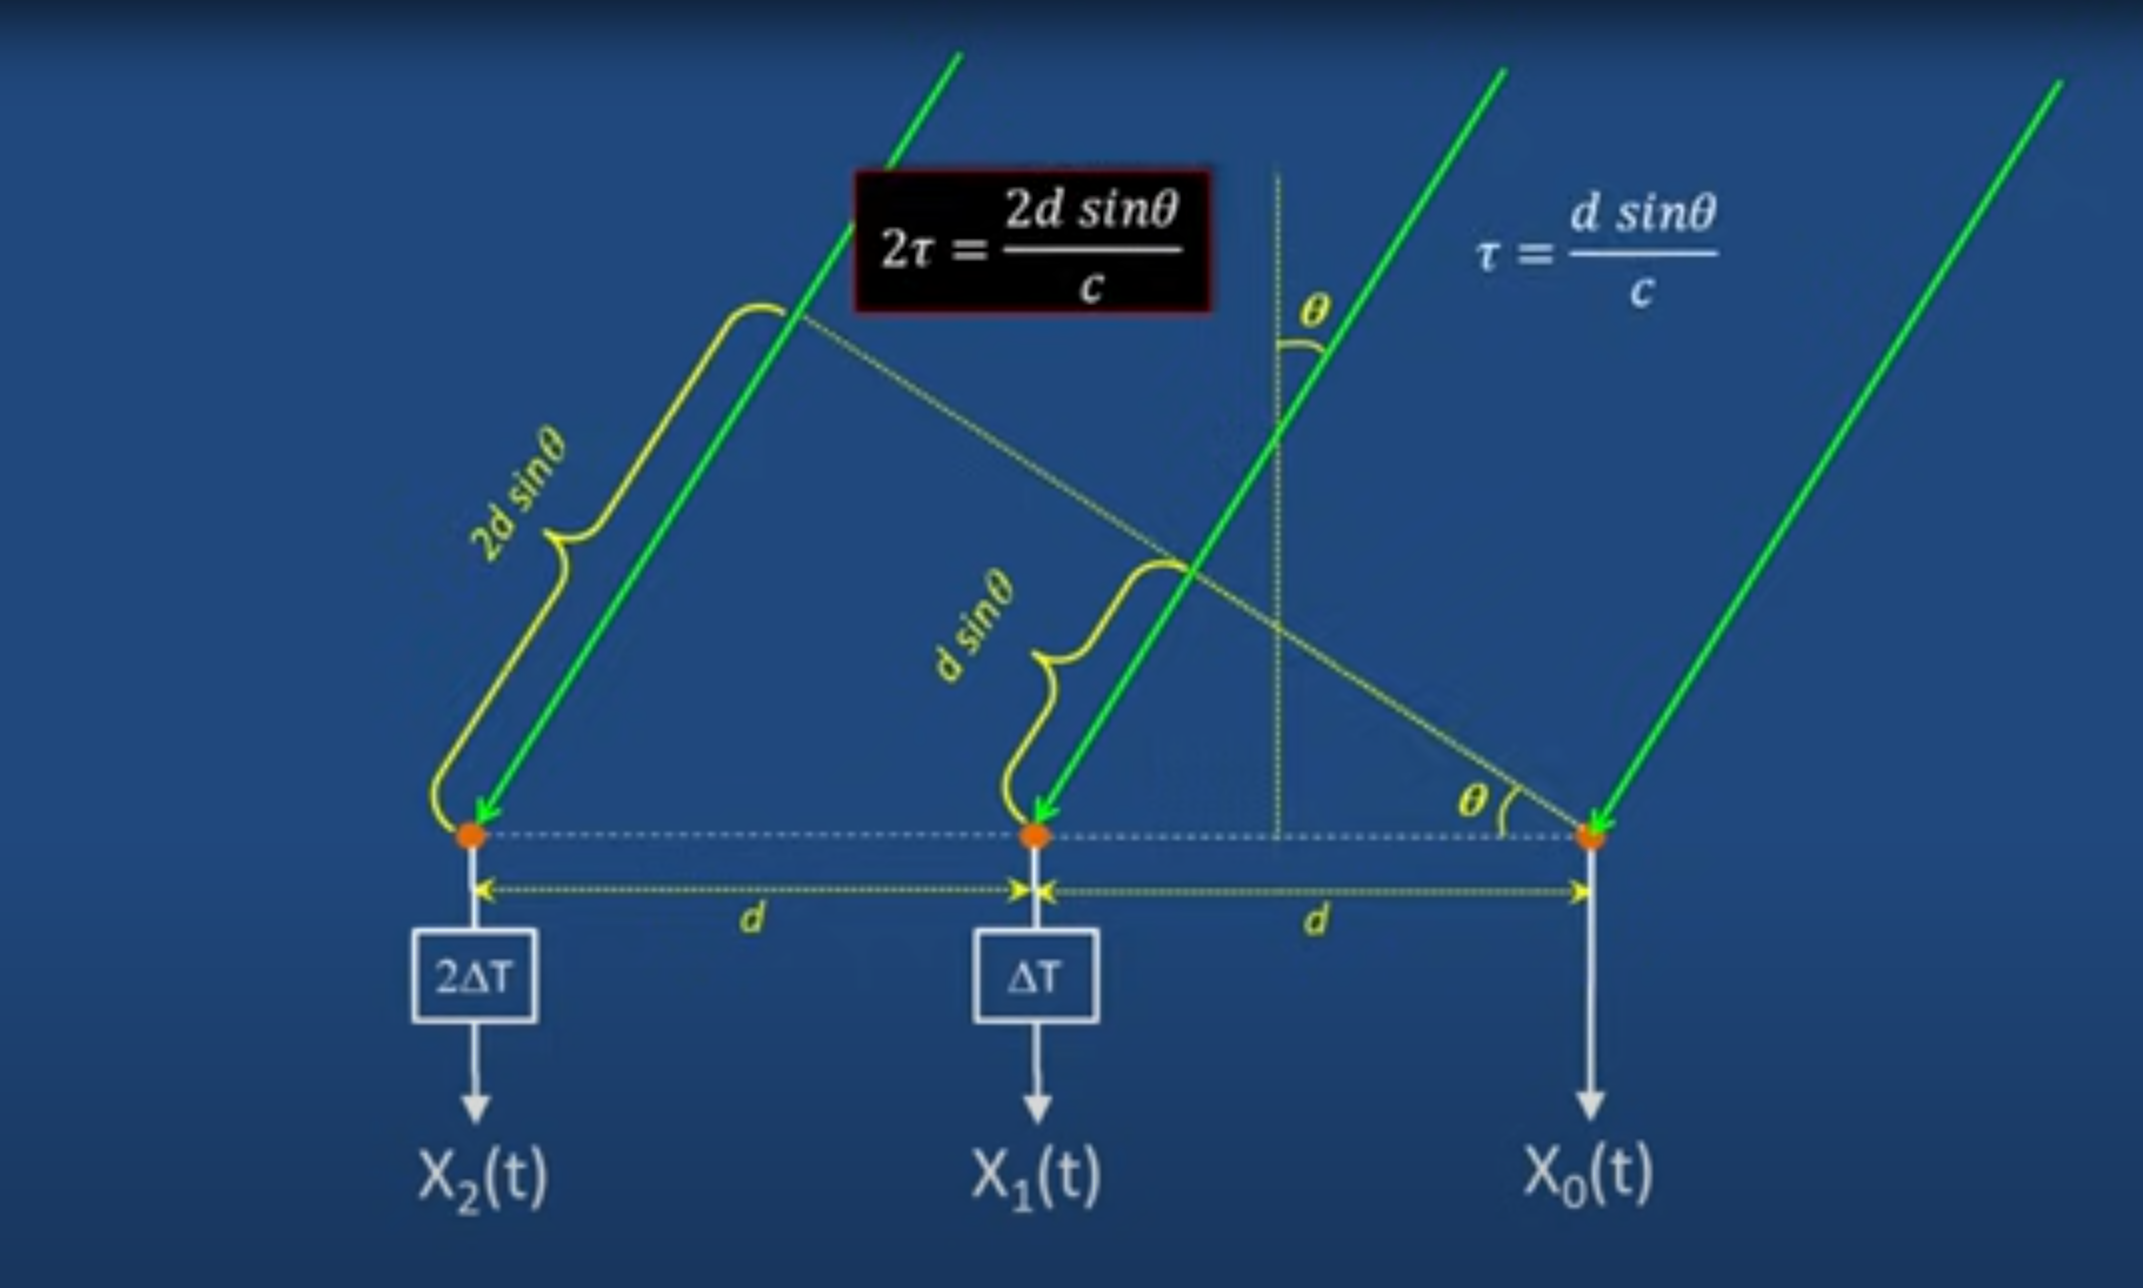

In [2]:

#freq = 1e9
#theta = 0 #np.pi
#lam = spc.c/freq
#d = .5 #half a wavelength
#tao = d*np.sin(theta)/spc.c

In [3]:
import matplotlib.pyplot as plt
import scipy.constants as spc
import numpy as np

[Example Code](https://pysdr.org/content/doa.html)

# Setup

In [4]:
sample_rate = 1e6
N = 10000 #number of samples

#create a tone
t = np.arange(N)/sample_rate
f_tone = 0.02e6
tx = np.exp(2j*np.pi*f_tone*t)

# Knobs

In [5]:
d = 0.5 # half wavelength spacing
Nr = 8
theta_degrees = 40 # direction of arrival (feel free to change this, it's arbitrary)
theta = theta_degrees / 180 * np.pi # convert to radians
s = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # Steering Vector
print(s) # note that it's 3 elements long, it's complex, and the first element is 1+0j

[ 1.        +0.j         -0.43368692-0.90106363j -0.62383132+0.78155901j
  0.97478188+0.22315979j -0.22166898-0.97512197j -0.78251201+0.62263549j
  0.90039942+0.43506424j  0.00152911-0.99999883j]


(8, 1)
(1, 10000)
(8, 10000)


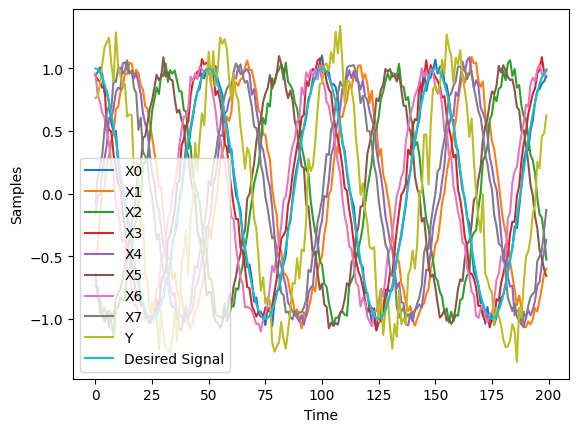

In [32]:
s = s.reshape(-1,1) #make s into a colum vector
print(s.shape) #should be Nrx1
tx = tx.reshape(1,-1) #make tx into a row vector
print(tx.shape) #should be 1xN

X = s@tx
print(X.shape)

#add noise to the signals
#n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
#X = X + 0.5*n # X and n are both 3x10000

X = X +  0.05*(np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N))
for i in range(len(X)):
    string = 'X'+str(i)
    plt.plot(np.asarray(X[i,:]).squeeze().real[0:200], label=string) # the asarray and squeeze are just annoyances we have to do because we came from a matrix
#plt.plot(np.asarray(X[1,:]).squeeze().real[0:200], label='X1')
#plt.plot(np.asarray(X[2,:]).squeeze().real[0:200], label='X2')

Y = np.zeros_like(X[0])
for i in range(len(X)):
    Y = Y+X[i]
plt.plot(np.asarray(Y).squeeze().real[0:200], label='Y')
plt.plot(np.asarray(tx).squeeze().real[0:200], label='Desired Signal')
plt.xlabel('Time')
plt.legend()
plt.ylabel("Samples")
plt.show()

# LMS

C:\Users\npdho\AppData\Local\Temp\ipykernel_10200\2263906920.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yreal[n] = (breal @ xv_real)# - (bimag @ xv_imag)
c:\Users\npdho\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


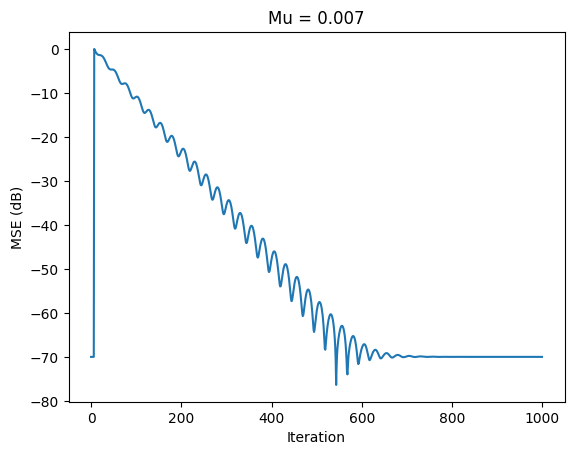

Complex weights [[ 0.25092541+0.0150471j  -0.09526468+0.21953257j -0.16829533-0.2054639j
   0.24123964-0.04131856j -0.04094962+0.24130254j -0.20572101-0.16798095j
   0.21938664-0.09560026j  0.01543077+0.25090211j]]


In [28]:


tx
x=X 
L=Nr-1 
mu=.007
N=N

ds = X[0].T.squeeze()
y = np.zeros_like(ds)
ereal = np.zeros_like(ds)
eimag = np.zeros_like(ds)
yreal = np.zeros_like(ds)
yimag = np.zeros_like(ds)
breal = np.zeros([1, L+1])
bimag = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv_real = np.array(xv).real
    #xv_imag = np.array(xv).imag

    #caclulate the output vector
    yreal[n] = (breal @ xv_real)# - (bimag @ xv_imag)
    #yimag[n] = (bimag @ xv_real) - (breal @ xv_imag)

    #calculate the error
    ereal[n] = ds[n] - yreal[n]
    #eimag[n] = ds[n].imag - yimag[n]


    #update the weights
    breal = breal + mu*(xv_real*ereal[n]).T#-xv_imag*eimag[n]).T
    #bimag = bimag + mu*(xv_real*eimag[n]-xv_imag*ereal[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
e = ereal #+ eimag
#freq_resp(bhat.reshape(L+1,1), [1])
eplot = 10*np.log10(e*e+.0000001)
plt.plot(eplot[0:1000])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()
b = breal+bimag
print("Complex weights", b)

C:\Users\npdho\AppData\Local\Temp\ipykernel_10200\3379378590.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yreal[n] = (breal @ xv_real)# - (bimag @ xv_imag)


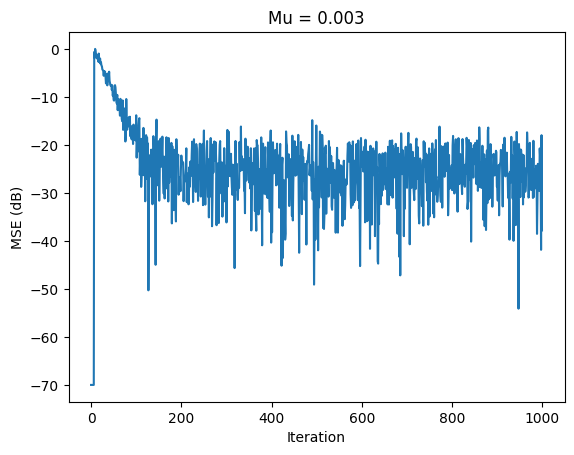

Complex weights [[ 2.47032515e-01+5.97267943e-05j -4.62502783e-02+9.75930178e-02j
  -6.72363491e-02-8.33154250e-02j  1.04893842e-01-2.37816829e-02j
  -2.41174347e-02+1.05995835e-01j -8.39265915e-02-6.68799785e-02j
   9.70841506e-02-4.80488709e-02j -1.10408070e-04+1.07141950e-01j]]


In [40]:
#sandbox

tx
x=X 
L=Nr-1 
mu=.003
N=N

ds = X[0].T.squeeze()
y = np.zeros_like(ds)
ereal = np.zeros_like(ds)
eimag = np.zeros_like(ds)
yreal = np.zeros_like(ds)
yimag = np.zeros_like(ds)
breal = np.zeros([1, L+1])
bimag = np.zeros([1, L+1])

for n in range(L,N):
    #define the input vector
    xv = []
    for i in range(X.shape[0]):
        xv.append(X[i][n])
    xv_real = np.array(xv)
    #xv_imag = np.array(xv).imag

    #caclulate the output vector
    yreal[n] = (breal @ xv_real)# - (bimag @ xv_imag)
    #yimag[n] = (bimag @ xv_real) - (breal @ xv_imag)

    #calculate the error
    ereal[n] = ds[n] - yreal[n]
    #eimag[n] = ds[n].imag - yimag[n]


    #update the weights
    breal = breal + mu*(xv_real.conj()*ereal[n]).T#-xv_imag*eimag[n]).T
    #bimag = bimag + mu*(xv_real*eimag[n]-xv_imag*ereal[n]).T
    
    #bhat = bhat + 2*mu*e[n]*xv
e = abs(ereal) #+ eimag
#freq_resp(bhat.reshape(L+1,1), [1])
eplot = 10*np.log10(e*e+.0000001)
plt.plot(eplot[0:1000])
plt.ylabel('MSE (dB)')
plt.xlabel('Iteration')
string = 'Mu = ' + str(mu)
plt.title(string)
plt.show()
b = breal+bimag
print("Complex weights", b)

c:\Users\npdho\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


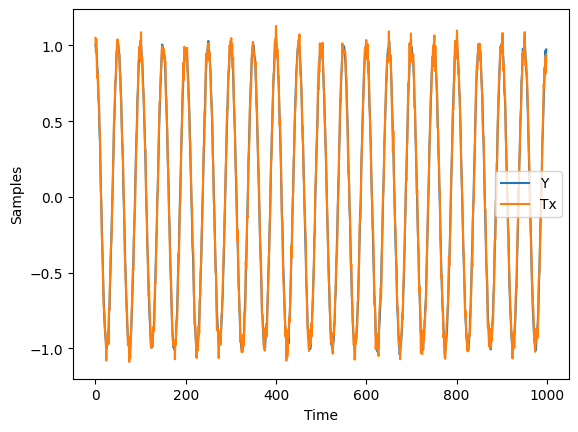

In [41]:
pointa=5000
pointb = pointa +1000
plt.plot(np.asarray(yreal)[pointa:pointb], label='Y')
plt.plot(np.asarray(X[0]).squeeze().real[pointa:pointb], label='Tx')
plt.xlabel('Time')
plt.legend()
plt.ylabel("Samples")
plt.show()

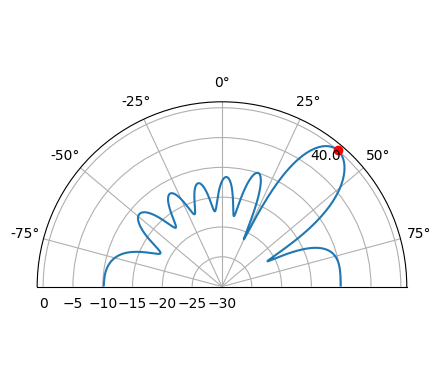

In [42]:
N_fft = 512
#theta_degrees = 20 # there is no SOI, we arent processing samples, this is just the direction we want to point at
#theta = theta_degrees / 180 * np.pi
#w = np.exp(-2j * np.pi * d * np.arange(Nr) * np.sin(theta)) # conventional beamformer
w = (breal) # or else our answer will be negative/inverted
w_padded = np.concatenate((w.reshape(w.shape[1]), np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

# find max so we can add it to plot
theta_max = theta_bins[np.argmax(w_fft_dB)]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB
plt.show()

In [10]:
X
X.shape[0]
x = []
for i in range(X.shape[0]):
    x.append(X[i][1])
x = np.array(x)

x.real



array([ 0.99570912, -0.39477058, -0.70700181,  0.89199307, -0.0797607 ,
       -0.9221903 ,  0.84328245,  0.16848683])

In [11]:
np.zeros(N_fft - Nr).shape

(504,)

In [12]:
int(np.ceil(X.shape[0]/2))

4

In [13]:
(bimag @ xv_real) + (breal @ xv_imag)

NameError: name 'xv_imag' is not defined